In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df_matches = pd.read_csv('../../data/preprocessed/preprocessed_1.csv')
df_matches.sort_values(by=["season", "stage", "date"], inplace=True)

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def train_and_evaluate(train_df, val_df, test_df, season, stage):
    feature_cols = [col for col in train_df.columns if col not in
                    ["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"]]

    X_train = train_df[feature_cols]
    y_train = train_df["result_match"]

    X_val = val_df[feature_cols]
    y_val = val_df["result_match"]

    X_test = test_df[feature_cols]
    y_test = test_df["result_match"]

    params = {'colsample_bytree': 0.9010421393996096,
              'gamma': 3.8019677435170545,
              'learning_rate': 0.31296122947271837,
              'max_depth': 10,
              'min_child_weight': 14.140141807395514,
              'n_estimators': 550,
              'reg_alpha': 0.05219808033947845,
              'reg_lambda': 0.33341766540428863,
              'subsample': 0.8566852088545951}

    y_train_value_counts = y_train.value_counts()
    ratio = y_train_value_counts[0] / y_train_value_counts[1]

    model = XGBClassifier(
        **params,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=ratio
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1, season, stage, y_test.tolist(), y_pred.tolist()

In [12]:
# ---------------------
# Backtesting over multiple seasons
# ---------------------

seasons = sorted(df_matches["season"].unique(), reverse=True)
backtest_results = []

for i in range(1, len(seasons)):
    target_season = seasons[0]
    previous_seasons = seasons[1:1 + i]

    target_season_df = df_matches[df_matches["season"] == target_season]

    target_stages = sorted(target_season_df["stage"].unique())

    for stage in target_stages:
        if stage <= min(target_stages) + 1:
            continue

        train_df_prev = df_matches[df_matches["season"].isin(previous_seasons)]
        train_df_target = target_season_df[target_season_df["stage"] < (stage - 1)]
        train_df = pd.concat([train_df_prev, train_df_target], ignore_index=True)

        val_df = target_season_df[target_season_df["stage"] == (stage - 1)]
        test_df = target_season_df[target_season_df["stage"] == stage]

        if train_df.empty or val_df.empty or test_df.empty:
            continue

        f1, season, stage, y_test, y_pred = train_and_evaluate(train_df, val_df, test_df, target_season, stage)

        backtest_results.append({
            "season": f"{season} - {len(previous_seasons)}",
            "stage": stage,
            "train_size": len(train_df),
            "f1_score": f1,
            "y_test": y_test,
            "y_pred": y_pred
        })

results_df = pd.DataFrame(backtest_results)
print("Backtesting results for each season and stage:")

Backtesting results for each season and stage:


In [13]:
results_df.to_csv('stages_results.csv', index=False)

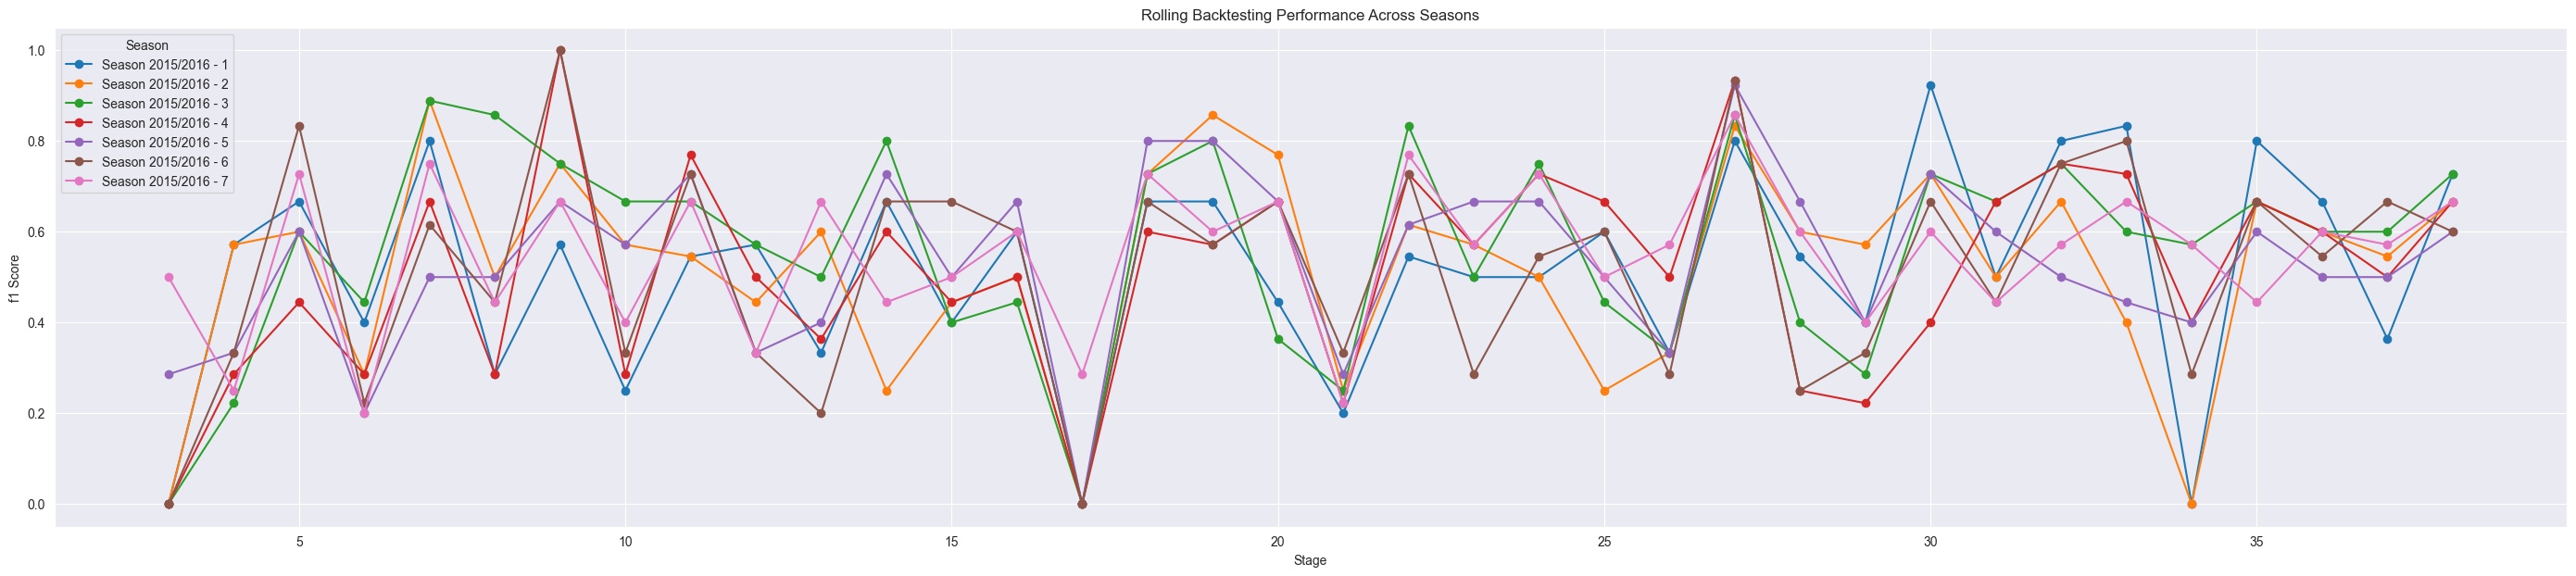

In [14]:
plt.figure(figsize=(35, 7))
for season in results_df["season"].unique():
    season_results = results_df[results_df["season"] == season]
    plt.plot(season_results["stage"], season_results["f1_score"], marker="o", label=f"Season {season}")

plt.xlabel("Stage")
plt.ylabel("f1 Score")
plt.title("Rolling Backtesting Performance Across Seasons")
plt.legend(title="Season")
plt.grid(True)
plt.show()


Average f1 Score for each season:
          season  avg_f1_score
0  2015/2016 - 1      0.513281
1  2015/2016 - 2      0.516752
2  2015/2016 - 3      0.562947
3  2015/2016 - 4      0.512974
4  2015/2016 - 5      0.533544
5  2015/2016 - 6      0.516681
6  2015/2016 - 7      0.549566


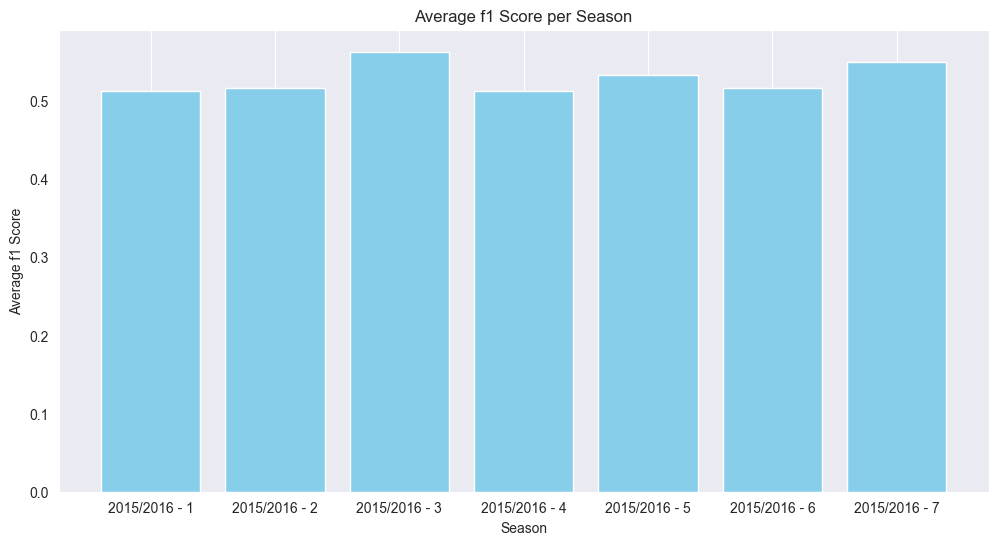

In [15]:
avg_results = results_df.groupby("season")["f1_score"].mean().reset_index()
avg_results.rename(columns={"f1_score": "avg_f1_score"}, inplace=True)
print("\nAverage f1 Score for each season:")
print(avg_results)

plt.figure(figsize=(12, 6))
plt.bar(avg_results["season"].astype(str), avg_results["avg_f1_score"], color='skyblue')
plt.xlabel("Season")
plt.ylabel("Average f1 Score")
plt.title("Average f1 Score per Season")
plt.grid(axis='y')
plt.show()

In [18]:
results_df[results_df["season"] == '2015/2016 - 3']

,season,stage,train_size,f1_score,y_test,y_pred
72,2015/2016 - 3,3,1131,0.000000,"[1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 1, 0, 0, 1]"
73,2015/2016 - 3,4,1139,0.222222,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1]","[1, 1, 0, 1, 1, 0, 1, 1, 0, 0]"
74,2015/2016 - 3,5,1148,0.600000,"[0, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[0, 0, 1, 0, 0, 1, 1, 0, 0, 0]"
75,2015/2016 - 3,6,1158,0.444444,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1]","[1, 0, 1, 1, 0, 1, 0, 1, 0, 1]"
76,2015/2016 - 3,7,1168,0.888889,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]"
77,2015/2016 - 3,8,1178,0.857143,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 1]","[0, 0, 0, 1, 1, 0, 0, 0, 1, 1]"
78,2015/2016 - 3,9,1188,0.750000,"[1, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]"
79,2015/2016 - 3,10,1198,0.666667,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 1]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
80,2015/2016 - 3,11,1208,0.666667,"[1, 0, 0, 0, 1, 0, 0, 1, 1, 1]","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]"
81,2015/2016 - 3,12,1218,0.571429,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 1]"


In [17]:
results_df.

,season,stage,train_size,f1_score,y_test,y_pred
0,2015/2016 - 1,3,379,0.000000,"[1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 1, 0, 0, 1]"
1,2015/2016 - 1,4,387,0.571429,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1]","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1]"
2,2015/2016 - 1,5,396,0.666667,"[0, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[1, 0, 1, 0, 1, 1, 1, 0, 0, 0]"
3,2015/2016 - 1,6,406,0.400000,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,2015/2016 - 1,7,416,0.800000,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 1, 1, 1, 1, 0, 0, 0, 1, 0]"
...,...,...,...,...,...,...
247,2015/2016 - 7,34,2915,0.571429,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 1, 1, 0, 1, 0]"
248,2015/2016 - 7,35,2925,0.444444,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 1]","[1, 0, 0, 1, 1, 0, 1, 1, 0, 0]"
249,2015/2016 - 7,36,2935,0.600000,"[1, 1, 1, 0, 1, 0, 1, 1, 0, 0]","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0]"
250,2015/2016 - 7,37,2945,0.571429,"[0, 0, 1, 1, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 1]"
